# Radar

## 1. Mô tả bài toán

Radar là một công nghệ then chốt trong truyền thông vô tuyến, có nhiều ứng dụng như xe tự hành. Nó thường gồm một anten phát các tín hiệu nhất định và thu lại các tín hiệu phản xạ từ các vật thể xung quanh. Bằng cách xử lý các tín hiệu này, hệ thống có thể xác định phương hướng góc, khoảng cách và vận tốc của các mục tiêu.

Trong ứng dụng thực tế, xử lý tín hiệu radar gặp nhiều khó khăn do nhiễu và các phản xạ từ những vật thể không phải mục tiêu trong môi trường. Ví dụ, khi cố gắng phát hiện người đi bộ, radar có thể đồng thời thu được phản xạ từ cây cối hoặc các vật nền khác, làm giảm độ chính xác. Nhiệm vụ của bạn là dùng AI để phân tích các tín hiệu thu được từ radar và xác định xem tại mỗi vị trí có con người hay không.

Trong bài này chúng tôi cung cấp một **bộ dữ liệu thí nghiệm radar trong nhà**, và mục tiêu của bạn là phát triển một mô hình thực hiện **phân đoạn ngữ nghĩa (semantic segmentation)** trên dữ liệu radar.

## 2. Bộ dữ liệu

Để đo các vật thể xung quanh radar, các tham số chính sau được sử dụng:

* **Range (khoảng cách)**: Khoảng cách thẳng giữa radar và một vật thể.
* **Azimuth (phương vị)**: Góc ngang (trái sang phải) giữa radar và vật thể.
* **Elevation (độ cao / góc chiều dọc)**: Góc thẳng đứng (lên hoặc xuống) của vật thể so với radar.
* **Velocity (vận tốc)**: Tốc độ vật thể đang tiến tới hay lùi khỏi radar.

<img src="figs/Radar Fig 1.png" width="300">

Dữ liệu radar được xử lý thành nhiều **bản đồ nhiệt (heatmaps)**, mỗi bản mã hóa **cường độ tín hiệu nhận được** ở các vị trí và hướng khác nhau.

* **Bản đồ nhiệt tĩnh (static heatmaps)** nhấn mạnh các phản xạ từ các vật thể **đứng yên**.
* **Bản đồ nhiệt động (dynamic heatmaps)** làm nổi bật các thay đổi do **vật thể chuyển động** gây ra.

Khi không có vật thể tại một vị trí cụ thể, tín hiệu chủ yếu là nhiễu nền và xuất hiện yếu. Ngược lại, phản xạ từ một vật thể sẽ làm tăng cường độ tín hiệu, cho phép phát hiện vật thể đó.

Ví dụ, **bản đồ nhiệt khoảng cách–phương vị tĩnh (static range-azimuth heatmap)** thể hiện cường độ tín hiệu theo các khoảng cách (**range**) và các góc ngang (**azimuth**), chủ yếu là phản xạ từ các vật thể tĩnh.

Mỗi mẫu trong bộ dữ liệu được lưu trong file `.mat.pt` dưới dạng tensor có kích thước $7 \times 50 \times 181$, trong đó:

* 7 là số bản đồ (6 bản đồ nhiệt + 1 bản đồ nhãn ngữ nghĩa),
* 50 tương ứng với số bin khoảng cách (range bins),
* 181 tương ứng với số bin góc hoặc vận tốc, bao phủ góc từ -90° đến +90° trong mặt phẳng ngang hoặc dọc. Bạn có thể giả định rằng các bin vận tốc cũng được ánh xạ lại từ -90° đến +90° để tiện trực quan hóa.
* mỗi giá trị cường độ trên bản đồ nhiệt đã được chuẩn hóa về [0, 1], biểu diễn cường độ tín hiệu nhận được.

6 bản đồ nhiệt được cấu trúc như sau:

* **Chỉ số 0**: Bản đồ tĩnh khoảng cách–phương vị (static range-azimuth heatmap)
* **Chỉ số 1**: Bản đồ động khoảng cách–phương vị (dynamic range-azimuth heatmap)
* **Chỉ số 2**: Bản đồ tĩnh khoảng cách–độ cao (static range-elevation heatmap)
* **Chỉ số 3**: Bản đồ động khoảng cách–độ cao (dynamic range-elevation heatmap)
* **Chỉ số 4**: Bản đồ tĩnh khoảng cách–vận tốc (static range-velocity heatmap)
* **Chỉ số 5**: Bản đồ động khoảng cách–vận tốc (dynamic range-velocity heatmap)

Tất cả giá trị trong các bản đồ nhiệt đều **đã được chuẩn hóa**, nên không cần chuyển đổi đơn vị.

**Bản đồ ở Chỉ số 6** là bản đồ nhãn ngữ nghĩa, lưu ở định dạng range-azimuth.

* **-1**: Nền (không có mục tiêu)
* **0**: Va-li (suitcase)
* **1**: Ghế (chair)
* **2**: Người (human)
* **3**: Tường (wall)

Đây là trực quan hóa file `1.mat.pt` trong `training_set`:

<img src="figs/Radar Fig 2.png" width="675">

Một phần mẫu dữ liệu:

<img src="figs/Radar Fig 3.png" width="675">

Quy mô dữ liệu: 1800 mẫu trong tập huấn luyện, 500 mẫu trong tập validation, và 500 mẫu trong tập test.

## 3. Nhiệm vụ

Nhiệm vụ của bạn là phát triển một mô hình nhận **sáu bản đồ nhiệt đầu tiên** (các chỉ số 0 đến 5) làm đầu vào, và dự đoán **bản đồ nhãn ngữ nghĩa** (chỉ số 6) làm đầu ra. Mục tiêu là xác định chính xác nhãn (từ -1 đến 3) tại mỗi vị trí trong trường nhìn của radar.

1. **Input**: Tensor có kích thước $6 \times 50 \times 181$, đại diện cho sáu bản đồ nhiệt radar.
2. **Output**: Tensor có kích thước $50 \times 181$, đại diện cho bản đồ nhãn ngữ nghĩa (label map).

## 4. Nộp bài

Vui lòng nộp một file tên `submission.ipynb`. Kết quả đầu ra là một file zip tên `submission.zip`, chứa hai bảng `submission_val.csv` và `submission_test.csv` tương ứng với kết quả dự đoán trên tập validation và tập test.

**Lưu ý:** Bảng kết quả chỉ cần có header; dữ liệu trong bảng không nhất thiết là dữ liệu đã giải xong, nó chỉ dùng làm ví dụ về định dạng nộp bài.

| filename | pixel_0 | pixel_1 | ... | pixel_9049 |
| :------: | :-----: | ------- | --- | ---------- |
| 1.mat.pt |    -1   | -1      | ... | -1         |
|    ...   |   ...   | ...     | ... | ...        |

## 5. Điểm số

Điểm được tính dựa trên **độ chính xác nhận diện nhãn**. Việc phát hiện đúng các điểm là mục tiêu (non-background) được tính trọng số lớn hơn so với việc nhận diện đúng các điểm nền.

### Tiêu chí chấm:

* Mỗi pixel nền (background) dự đoán đúng được **1 điểm**.
* Mỗi pixel không phải nền (non-background) dự đoán đúng được **50 điểm**.
* Điểm cuối cùng được chuẩn hóa về thang **0–1** bằng cách so sánh với điểm tối đa có thể đạt được.

### Công thức：

$$
Score = \frac{|C_{0,correct}| \times 1 + |C_{1,correct}| \times bonus}{|C_0| \times 1 + |C_1| \times bonus}
$$
với:

$$
\begin{aligned}
I &= {1, 2, \dots, 50\times 181}\
C_0 &= {i \in I \mid y_i = -1}\
C_1 &= {i \in I \mid y_i \neq -1}\
C_{0,correct} &= {i \in C_0 \mid p_i = y_i}\
C_{1,correct} &= {i \in C_1 \mid p_i = y_i}\
\end{aligned}
$$

### Ví dụ

Với bản đồ $3\times3$, giả sử Ground Truth là:

$$
\begin{bmatrix}
-1 & -1 & -1 \
1 & 2 & 3 \
-1 & -1 & -1
\end{bmatrix}
$$

Kết quả mong muốn là:

$$
\begin{bmatrix}
-1 & 1 & -1 \
-1 & 2 & -1 \
-1 & 3 & -1
\end{bmatrix}
$$

Khi đó có bốn pixel `-1` dự đoán đúng và một pixel `2` dự đoán đúng. Điểm của bạn là 4 + 50 = 54. Điểm tối đa có thể là 6 + 50 * 3 = 156 (tức là 6 pixel nền và 3 pixel non-background). Điểm chuẩn hóa là 54 / 156 = 0.346.

$$
Score = \frac{4 \times 1 + 1 \times 50}{6 \times 1 + 3 \times 50}=0.346
$$

## 6. Baseline và Tập huấn luyện

* Dưới đây bạn có thể tìm giải pháp baseline.
* Bộ dữ liệu nằm trong thư mục `training_set`.
* Điểm cao nhất do Ban khoa học đạt được cho bài này là 0.90 trên Leaderboard B; điểm này dùng để chuẩn hóa điểm.
* Điểm baseline do Ban khoa học cho là 0.67 trên Leaderboard B; điểm này cũng dùng để chuẩn hóa điểm.


In [6]:
import torch
import cv2
import matplotlib.pyplot as plt
tensor = torch.load(r"E:\Luyen-AIO\IOAI-2025-main\IOAI-2025-main\Individual-Contest\Radar\training_set\1.mat.pt")

C:\Users\Vitus\AppData\Local\Temp\ipykernel_26116\1291004481.py:4: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  tensor = torch.load(r"E:\Luyen-AIO\IOAI-2025-main\IOAI-2025-

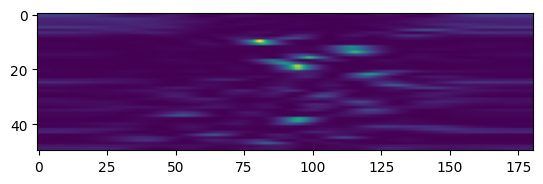

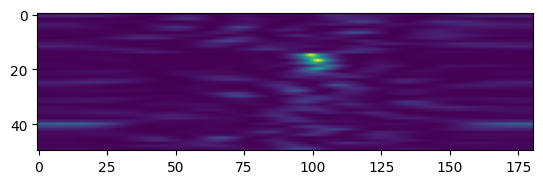

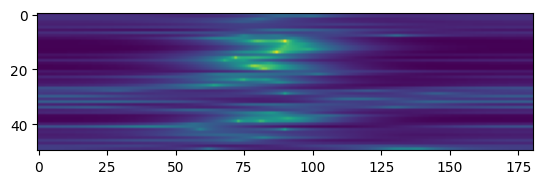

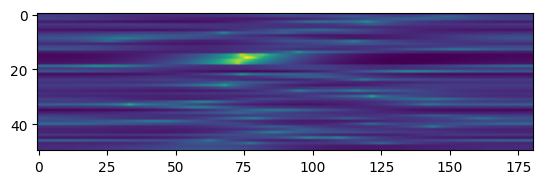

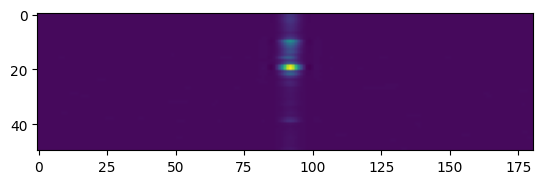

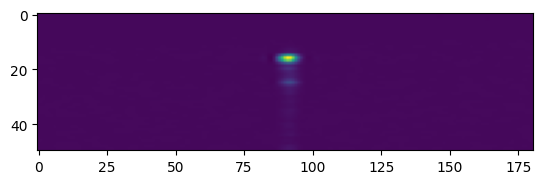

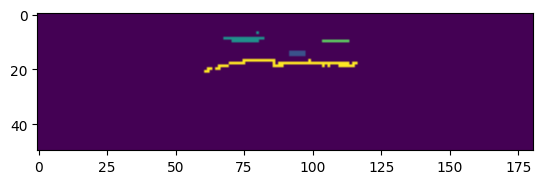

In [7]:
for i in range(tensor.numpy().shape[0]):
    plt.imshow(tensor.numpy()[i])
    plt.show()

In [8]:
from torch.utils.data import Dataset, DataLoader
from torchvision.models.segmentation import deeplabv3_resnet50
model = deeplabv3_resnet50(weights = None)
print(model.backbone)


IntermediateLayerGetter(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1

In [9]:
from torchvision.models import efficientnet_b0, EfficientNet_B0_Weights
backbone = efficientnet_b0(weights = False)
print(backbone)
del backbone.avgpool
del backbone.classifier

EfficientNet(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): SiLU(inplace=True)
    )
    (1): Sequential(
      (0): MBConv(
        (block): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
            (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (2): SiLU(inplace=True)
          )
          (1): SqueezeExcitation(
            (avgpool): AdaptiveAvgPool2d(output_size=1)
            (fc1): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
            (fc2): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
            (activation): SiLU(inplace=True)
            (scale_activation): Sigmoid()
          )
          (2): Conv2dNormActivat

In [10]:
model.backbone = backbone

In [11]:
print(model)

DeepLabV3(
  (backbone): EfficientNet(
    (features): Sequential(
      (0): Conv2dNormActivation(
        (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
        (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): SiLU(inplace=True)
      )
      (1): Sequential(
        (0): MBConv(
          (block): Sequential(
            (0): Conv2dNormActivation(
              (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
              (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
              (2): SiLU(inplace=True)
            )
            (1): SqueezeExcitation(
              (avgpool): AdaptiveAvgPool2d(output_size=1)
              (fc1): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
              (fc2): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
              (activation): SiLU(inplace=True)
              (scale_ac

In [12]:
preprocess = EfficientNet_B0_Weights.transforms

In [ ]:
import inspect
import torchvision
functions = inspect.getmembers(torchvision, inspect.isfunction)
for name, func in functions:
    print(name)
# Liệt kê tất cả hàm trong torchvision.utils
import torchvision.utils as utils
functions = inspect.getmembers(utils, inspect.isfunction)

for name, func in functions:
    print(name)

_is_tracing
disable_beta_transforms_warning
get_image_backend
get_video_backend
set_image_backend
set_video_backend
_generate_color_palette
_log_api_usage_once
_make_colorwheel
_make_ntuple
_normalized_flow_to_image
_parse_colors
draw_bounding_boxes
draw_keypoints
draw_segmentation_masks
flow_to_image
make_grid
save_image


In [36]:
tensor = torch.load(r"E:\Luyen-AIO\IOAI-2025-main\IOAI-2025-main\Individual-Contest\Radar\Solution\validation_set\1.mat.pt")

C:\Users\Vitus\AppData\Local\Temp\ipykernel_26116\1736656853.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  tensor = torch.load(r"E:\Luyen-AIO\IOAI-2025-main\IOAI-2025-

In [20]:
df = pd.read_csv(r"E:\Luyen-AIO\IOAI-2025-main\IOAI-2025-main\Individual-Contest\Radar\Solution\validation_set\labels\ground_truth_val.csv")
df

filename  pixel_0  pixel_1  pixel_2  pixel_3  pixel_4  pixel_5  \
0    283.mat.pt       -1       -1       -1       -1       -1       -1   
1    138.mat.pt       -1       -1       -1       -1       -1       -1   
2    420.mat.pt       -1       -1       -1       -1       -1       -1   
3    405.mat.pt       -1       -1       -1       -1       -1       -1   
4     40.mat.pt       -1       -1       -1       -1       -1       -1   
..          ...      ...      ...      ...      ...      ...      ...   
495  498.mat.pt       -1       -1       -1       -1       -1       -1   
496  402.mat.pt       -1       -1       -1       -1       -1       -1   
497  479.mat.pt       -1       -1       -1       -1       -1       -1   
498    8.mat.pt       -1       -1       -1       -1       -1       -1   
499  107.mat.pt       -1       -1       -1       -1       -1       -1   

     pixel_6  pixel_7  pixel_8  ...  pixel_9040  pixel_9041  pixel_9042  \
0         -1       -1       -1  ...          -1          -1          -1   
1         -1       -1       -1  ...          -1          -1          -1   
2         -1       -1       -1  ...          -1          -1          -1   
3         -1       -1       -1  ...          -1          -1          -1   
4         -1       -1       -1  ...          -1          -1          -1   
..       ...      ...      ...  ...         ...         ...         ...   
495       -1       -1       -1  ...          -1          -1          -1   
496       -1       -1       -1  ...          -1          -1          -1   
497       -1       -1       -1  ...          -1          -1          -1   
498       -1       -1       -1  ...          -1          -1          -1   
499       -1       -1       -1  ...          -1          -1          -1   

     pixel_9043  pixel_9044  pixel_9045  pixel_9046  pixel_9047  pixel_9048  \
0            -1          -1          -1          -1          -1          -1   
1            -1          -1          -1          -1          -1          -1   
2            -1          -1          -1          -1          -1          -1   
3            -1          -1          -1          -1          -1          -1   
4            -1          -1          -1          -1          -1          -1   
..          ...         ...         ...         ...         ...         ...   
495          -1          -1          -1          -1          -1          -1   
496          -1          -1          -1          -1          -1          -1   
497          -1          -1          -1          -1          -1          -1   
498          -1          -1          -1          -1          -1          -1   
499          -1          -1          -1          -1          -1          -1   

     pixel_9049  
0            -1  
1            -1  
2            -1  
3            -1  
4            -1  
..          ...  
495          -1  
496          -1  
497          -1  
498          -1  
499          -1  

[500 rows x 9051 columns]

In [57]:
from torch.utils.data import Dataset, DataLoader
import os
import pandas as pd

class TrainDataset(Dataset):
    def __init__(self, transform=None):
        super().__init__()
        self.transform = transform
    
    def __len__(self):
        return len(os.listdir(r"E:\Luyen-AIO\IOAI-2025-main\IOAI-2025-main\Individual-Contest\Radar\training_set"))
    
    def __getitem__(self, idx):
        tensor = torch.load(os.path.join(r"E:\Luyen-AIO\IOAI-2025-main\IOAI-2025-main\Individual-Contest\Radar\training_set", f"{idx+1}.mat.pt"))
        if self.transform:
            tensor = self.transform(tensor)
        return {'data': tensor[:-1], 'label': tensor[-1]}
    
class TestDataset(Dataset):
    def __init__(self, data_path, label_path, transform=None):
        super().__init__()
        self.transform = transform
        self.data_path = data_path
        self.labels = pd.read_csv(label_path)
    def __len__(self):
        files = [file for file in os.listdir(self.data_path) if file.endswith('.pt')]
        return len(files)
    def __getitem__(self, idx):
        data = torch.load(os.path.join(self.data_path, f"{idx+1}.mat.pt"))
        if self.transform:
            data = self.transform(data)
        label_row = self.labels[self.labels['filename'] == f"{idx+1}.mat.pt"]
        if not label_row.empty:
            pixel_columns = [col for col in self.labels.columns if col.startswith('pixel_')]
            label = torch.tensor(label_row[pixel_columns].values[0], dtype=torch.long)
            label = label.reshape(50,181)

        return {
            'data': data,
            'label': label
        }

In [66]:
dataset = TrainDataset()
public_test_dataset = TestDataset(r"E:\Luyen-AIO\IOAI-2025-main\IOAI-2025-main\Individual-Contest\Radar\Solution\validation_set", r"E:\Luyen-AIO\IOAI-2025-main\IOAI-2025-main\Individual-Contest\Radar\Solution\validation_set\labels\ground_truth_val.csv")
private_test_dataset = TestDataset(r"E:\Luyen-AIO\IOAI-2025-main\IOAI-2025-main\Individual-Contest\Radar\Solution\test_set", r"E:\Luyen-AIO\IOAI-2025-main\IOAI-2025-main\Individual-Contest\Radar\Solution\test_set\labels\ground_truth_test.csv")

In [68]:
from torch.utils.data import random_split
from pytorch_lightning import seed_everything
seed_everything(42, workers=4, verbose=False)
train_size = int(len(dataset) * 0.2)
valid_size = len(dataset) - train_size
train_dataset, valid_dataset = random_split(dataset=dataset, lengths=[train_size, valid_size])

In [ ]:
from torch.utils.data.sampler import WeightedRandomSampler


In [69]:
train_dataloader = DataLoader(dataset=train_dataset,
                              batch_size=36,
                            #   sampler=
                            shuffle=True,
                            num_workers=4
                            )
valid_dataloader = DataLoader(dataset=valid_dataset,
                              batch_size=36,
                            #   sampler=
                            shuffle=True,
                            num_workers=4
                            )

In [ ]:
from pytorch_lightning import LightningModule, Trainer
from pytorch_lightning.loggers import TensorBoardLogger
from pytorch_lightning.callbacks import ModelCheckpoint, EarlyStopping
from torchvision.ops import sigmoid_focal_loss

class WrapperModel(LightningModule):
    def __init__(self):
        super().__init__()
        self.save_hyperparameters()
        self.model = model
        self.loss = sigmoid_focal_loss

In [ ]:
import torch.nn.functional as F
class FocalLoss(LightningModule):
    def __init__(self, alpha=0.25, gamma=2.0):
        super().__init__()
        self.alpha = alpha
        self.gamma = gamma

    def forward(self, inputs, targets):
        # Inputs: (N, C, H, W) - logits cho C classes
        # Targets: (N, H, W) - class indices (0, 1, 2, ..., C-1)
        ce_loss = F.cross_entropy(inputs, targets, reduction="none")
        pt = torch.exp(-ce_loss)
        focal_loss = self.alpha * (1 - pt) ** self.gamma * ce_loss
        return focal_loss.mean()
    
class DiceLoss(LightningModule):
    def __init__(self, smooth=1e-6):
        super().__init__()
        self.smooth = smooth

    def forward(self, inputs, targets):
        # Inputs: (N, C, H, W) - logits cho C classes
        # Targets: (N, H, W) - class indices (0, 1, 2, ..., C-1)
        inputs = torch.softmax(inputs, dim=1)
        targets_one_hot = F.one_hot(targets, num_classes=inputs.shape[1]).permute(0, 3, 1, 2).float()

        intersection = (inputs * targets_one_hot).sum(dim=(2, 3))
        union = inputs.sum(dim=(2, 3)) + targets_one_hot.sum(dim=(2, 3))

        dice_score = (2. * intersection + self.smooth) / (union + self.smooth)
        dice_loss = 1 - dice_score.mean()
        return dice_loss

AttributeError: type object 'DFineConfig' has no attribute 'matcher_class_cost'